In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = 16,8

from collections import Counter,defaultdict
from itertools import chain, combinations

import warnings
warnings.filterwarnings('ignore')

import imshow
from wordcloud import WordCloud
from PIL import Image

import re
from collections import Counter
from itertools import chain
import pickle

import sent2vec
import hnswlib
from gensim.models import Word2Vec
from gensim import corpora
from scipy.sparse import *
from scipy.sparse.linalg import svds


In [15]:
# -------
from py_file.total_processing import *
kp = konlpy_preprocessing()

In [16]:
train = pd.read_json('/home/ubuntu/workspace/jh/project/data/train.json')

In [17]:
s2v_model = sent2vec.Sent2vecModel()
s2v_model.load_model('/home/ubuntu/workspace/jh/project/model/s2v_model.bin')
p_title_s2v = pickle.load(open('/home/ubuntu/workspace/jh/project/model/p_title.pickle', 'rb'))
p_tags_s2v = pickle.load(open('/home/ubuntu/workspace/jh/project/model/p_tags.pickle', 'rb'))
p_new_tags_s2v = pickle.load(open('/home/ubuntu/workspace/jh/project/model/p_new_tags.pickle', 'rb'))

w2v_model = Word2Vec.load('/home/ubuntu/workspace/jh/project/model/w2v.model')
p_tags_w2v = pickle.load(open('/home/ubuntu/workspace/jh/project/model/w2v_p_tags.pickle', 'rb'))
p_titles_w2v = pickle.load(open('/home/ubuntu/workspace/jh/project/model/w2v_p_titles.pickle', 'rb'))
p_new_tags_w2v = pickle.load(open('/home/ubuntu/workspace/jh/project/model/w2v_p_new_tags.pickle', 'rb'))

# 1. Word2Vec와 Sent2Vec의 wordcloud

- word2vec과 sent2vec는 일반화할 수 있는 평가지표가 없다
- 그렇기 때문에 wordcloud를 만들어서 어느 정도인지 확인할 수 있을 것이다

## 1_1. 단어 빈도 dict 만들기

- word2vec와 sent2vec 모델을 통해 나온 knn 모델을 통해 각각 30개의 플레이리스트를 가져옴
- 가져온 플레이 리스트에서 유저가 직접 입력한 태그의 빈도를 dict 형태로 변환함

In [18]:
def word_count(text, k_n = 10):
    test_tag = kp.konlpy_preprocessing(text)

    test_tag = test_tag.split()
    test_tag = " ".join([i for i in test_tag if s2v_model.embed_sentence(i).sum() != 0])

    try:
        text = test_tag.split()
        tag_emb = [w2v_model.wv.get_vector(x) for x in text]

        emb = sum(tag_emb)/len(tag_emb)

        title_labels, title_distances = p_titles_w2v.knn_query(emb, k = k_n, num_threads=8)
        tag_labels, tags_distances = p_tags_w2v.knn_query(emb, k = k_n, num_threads=8)
        new_tag_labels, new_tags_distances = p_new_tags_w2v.knn_query(emb, k = k_n, num_threads=8)
    
        reco_idx = list(chain.from_iterable(zip(title_labels.reshape(-1),tag_labels.reshape(-1),new_tag_labels.reshape(-1))))
        w2v_count = Counter(np.concatenate(train.iloc[reco_idx]['tags'].tolist()))

        w2v_words = dict(w2v_count.most_common())
    
    except ValueError and ZeroDivisionError:
        
        print('다시 입력해주세요!')
        return None,None



    if s2v_model.embed_sentence(test_tag).sum() == 0.0:
        print()    
    else:
        emb = s2v_model.embed_sentence(test_tag)
        title_labels, title_distances = p_title_s2v.knn_query(emb, k = k_n, num_threads=8)
        tag_labels, tags_distances = p_tags_s2v.knn_query(emb, k = k_n, num_threads=8)
        new_tag_labels, new_tags_distances = p_new_tags_s2v.knn_query(emb, k = k_n, num_threads=8)

        reco_idx = list(chain.from_iterable(zip(title_labels.reshape(-1),tag_labels.reshape(-1),new_tag_labels.reshape(-1))))

        s2v_count = Counter(np.concatenate(train.iloc[reco_idx]['tags'].tolist()))
        s2v_words = dict(s2v_count.most_common())

        return w2v_words,s2v_words

# wordcloud 함수 생성

- ww를 통해 어떤 모델의 wordcloud를 볼 지 설정 가능
    - "w" : word2vec
    - "s" : sent2vec
    - "compare"  word2vec과 sent2vec 비교 (default)


- save를 통해 모델을 저장할 수 있음 (default : "off")

- 아래의 color_func함수를 통해 hsl코드를 변경해 색의 범위를 지정해 줄 수 있음
    - [색 변경 코드 확인](https://www.w3schools.com/colors/colors_picker.asp)

In [19]:
def wc_compare(text, ww = 'compare', save = 'off'):
    w2v_words, s2v_words = word_count(text)
    
    if ww == 'w':
        fig, ax = plt.subplots()
        wc = WordCloud(font_path=r'/home/ubuntu/workspace/font/GmarketSansTTFMedium.ttf',
                        max_words=100,
                        background_color='white',
                        color_func = color_func,
                        relative_scaling  = 0.2,
                        width = 3000,
                        height = 2000)

        w = wc.generate_from_frequencies(w2v_words)
        ax.imshow(w, interpolation="bilinear")
        ax.set_title('Word2Vec Wordcloud')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if save == 'on':
            plt.savefig(f'/home/ubuntu/workspace/wordcloud_images/w2v_{text}.png')

    elif ww == 's':
        fig, ax = plt.subplots()
        wc = WordCloud(font_path=r'/home/ubuntu/workspace/font/GmarketSansTTFMedium.ttf',
                        max_words=100,
                        background_color='white',
                        color_func = color_func,
                        relative_scaling  = 0.2,
                        width = 3000,
                        height = 2000)

        s = wc.generate_from_frequencies(s2v_words)
        ax.imshow(s, interpolation="bilinear")
        ax.set_title('Sent2Vec Wordcloud')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        if save == 'on':
            plt.savefig(f'/home/ubuntu/workspace/wordcloud_images/s2v_{text}.png')
        
    
    else:
        fig, ax = plt.subplots(1,2)
        wc = WordCloud(font_path=r'/home/ubuntu/workspace/font/GmarketSansTTFMedium.ttf',
                        max_words=100,
                        background_color='white',
                        color_func = color_func,
                        relative_scaling  = 0.2,
                        width = 3000,
                        height = 2000)

        w = wc.generate_from_frequencies(w2v_words)
        ax[0].imshow(w, interpolation="bilinear")
        ax[0].set_title('Word2Vec Wordcloud')
        ax[0].axes.xaxis.set_visible(False)
        ax[0].axes.yaxis.set_visible(False)

        s = wc.generate_from_frequencies(s2v_words)
        ax[1].imshow(s, interpolation="bilinear")
        ax[1].set_title('Sent2Vec Wordcloud')
        ax[1].axes.xaxis.set_visible(False)
        ax[1].axes.yaxis.set_visible(False)
        
        if save == 'on':
            plt.savefig(f'/home/ubuntu/workspace/fffff/05_1.{text}.png')
        
    plt.show()

In [20]:
def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return(f"hsl({np.random.randint(18,45)},{np.random.randint(99,100)}%, {np.random.randint(30,70)}%)")

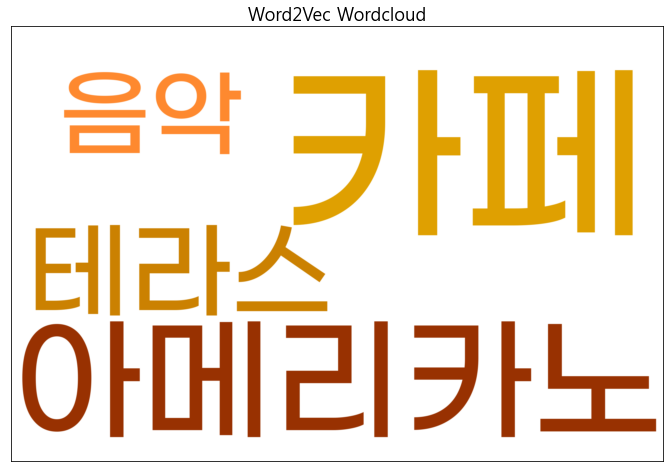

In [21]:
wc_compare('카페', save = 'off', ww= 'w')


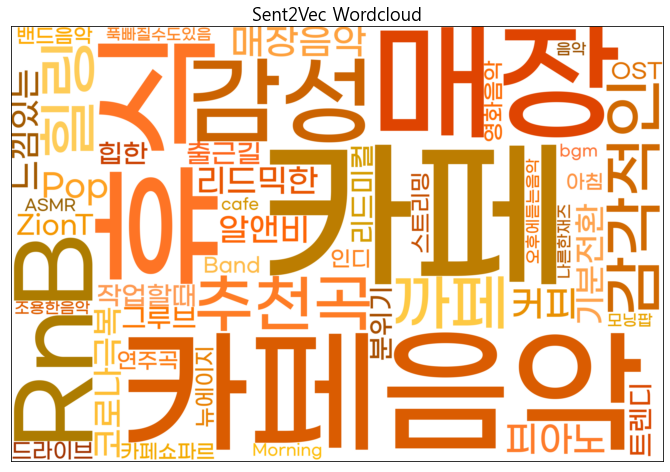

In [39]:
wc_compare('카페', save = 'off', ww= 's')

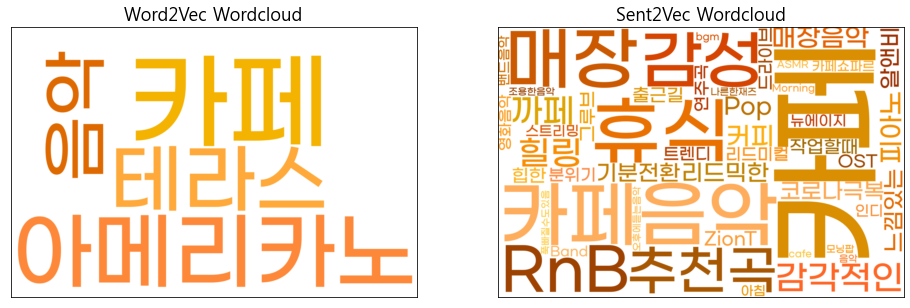

In [22]:
wc_compare('카페', save = 'off', ww= 'compare')